In [2]:
import os
os.chdir("/home/mohsen/projects/scarches/")

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import scarches as sca
from matplotlib import pyplot as plt
sc.settings.set_figure_params(dpi=200, frameon=False)

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [5]:
sc.set_figure_params(dpi=200)

In [6]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]

# Loading 5 Pancreas datasets and data preparation

In [7]:
adata = sc.read("/home/mohsen/data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [8]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we leave out two studies for training the newtork

In [9]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [10]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
conditions = source_adata.obs[condition_key].unique().tolist()
conditions

['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1']

# Create & Train model with training data

In [13]:
network = sca.models.scArches(task_name="pancreas-inDrop,CelSeq,FluidigmC1",
                              x_dimension=source_adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 64, 32],
                              conditions=conditions,
                              gene_names=source_adata.var_names.tolist(),
                              lr=0.001,
                              alpha=0.00005,
                              beta=1000.0,
                              eta=1.0,
                              use_batchnorm=False,
                              clip_value=1000.0,
                              loss_fn='sse',
                              model_path="./models/scNet/pancreas/before/",
                              dropout_rate=0.05,
                              output_activation='relu')

W0726 15:54:05.762405 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0726 15:54:05.764048 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0726 15:54:05.765254 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0726 15:54:06.097863 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


## Training the network

In [14]:
network.train(source_adata,
              train_size=0.8,
              condition_key=condition_key,
              n_epochs=1000,
              batch_size=1024,
              early_stop_limit=15,
              lr_reducer=10,
              save=True,
              retrain=True,
              )

W0726 15:57:58.749247 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0726 15:57:59.004420 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0726 15:57:59.281010 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0726 15:58:00.001321 140121776727872 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Plea

 |██████--------------| 33.6%  - loss: 1056.1438 - mmd_loss: 56.8774 - reconstruction_loss: 999.2665 - val_loss: 1027.6079 - val_mmd_loss: 51.4133 - val_reconstruction_loss: 976.194744
scArches has been successfully saved in ./models/scNet/pancreas/before/pancreas-inDrop,CelSeq,FluidigmC1.


In [18]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [21]:
latent_adata = network.get_latent(source_adata, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 8235 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

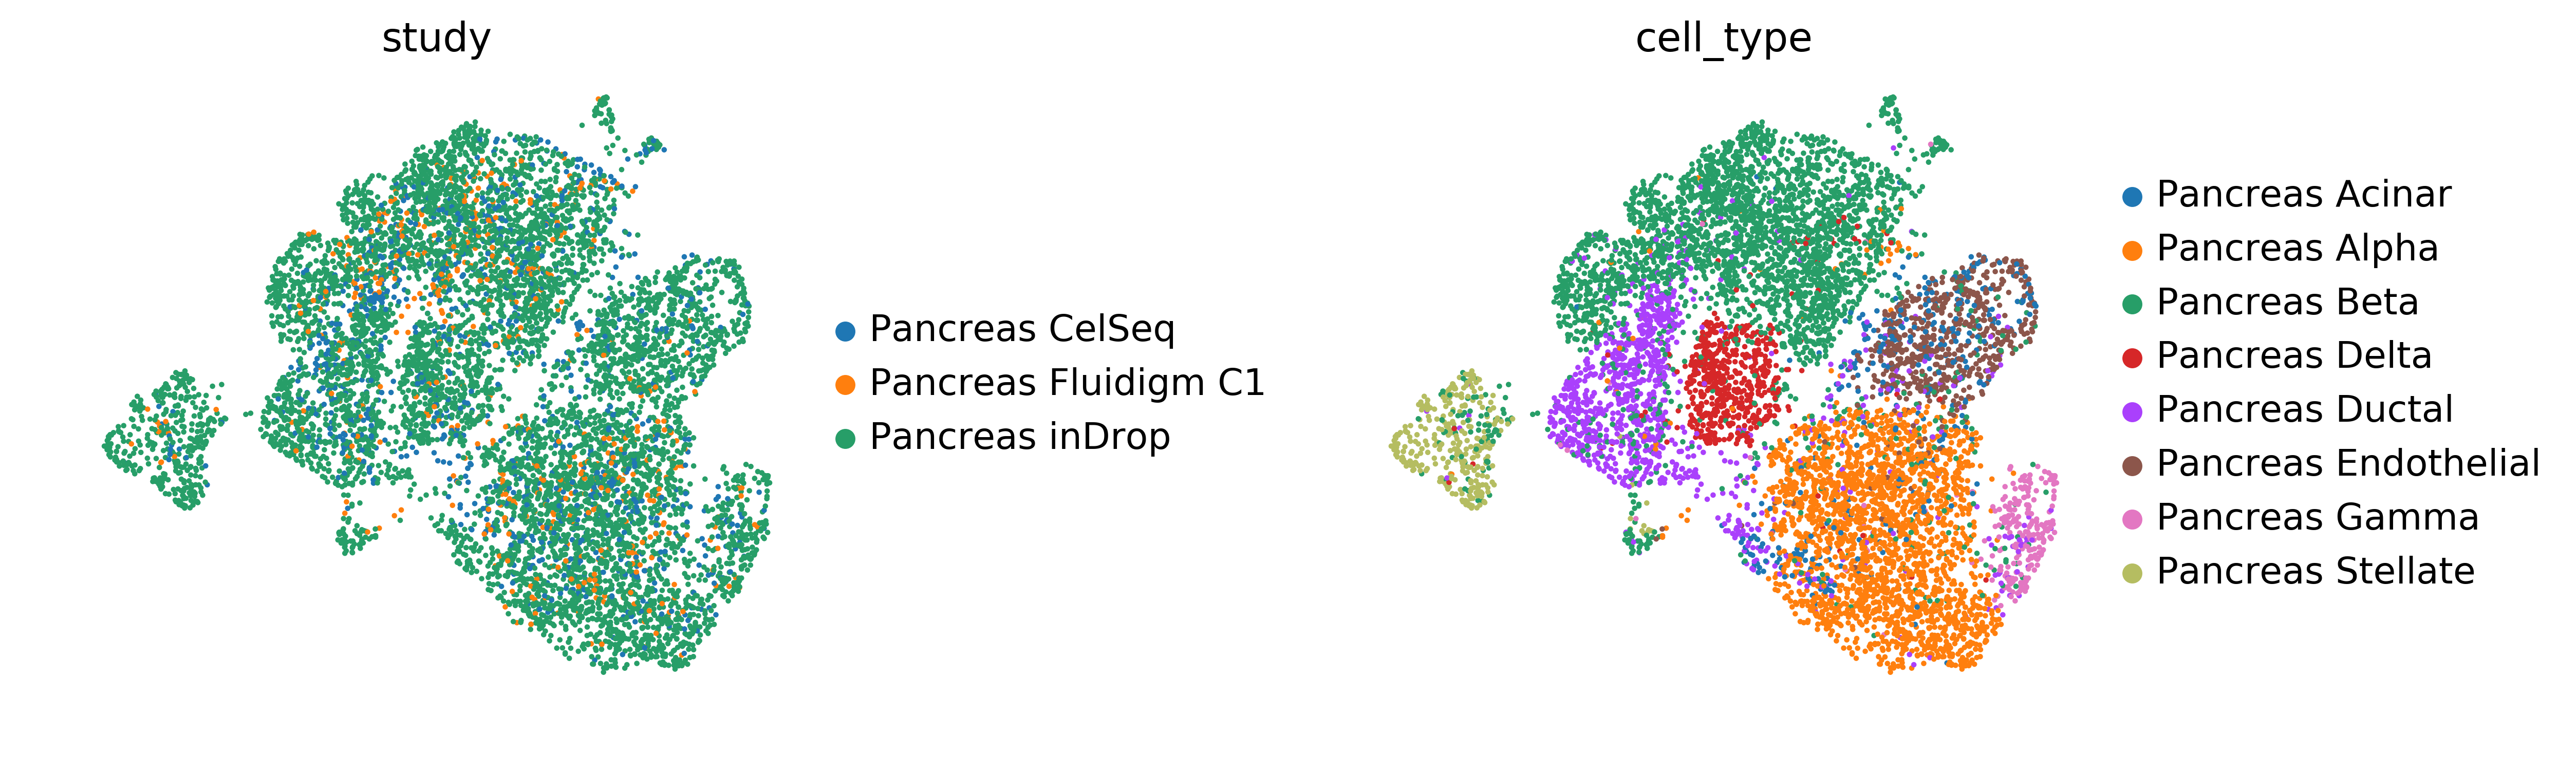

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           frameon=False, wspace=0.6)

# Perfroming architecture Surgery

In [15]:
new_network = sca.operate(network, 
                          new_task_name='after',
                          new_conditions=target_conditions,
                          init='Xavier', 
                          version='scArches',
                          remove_dropout=False)

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [16]:
new_network.condition_encoder

{'Pancreas CelSeq': 0,
 'Pancreas Fluidigm C1': 1,
 'Pancreas inDrop': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

## Train with small new datasets

In [17]:
new_network.train(target_adata,
                  train_size=0.8, 
                  condition_key=condition_key,
                  n_epochs=1000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40,
                  save=True, 
                  retrain=True,)

 |███████████████-----| 78.6%  - loss: 1176.1558 - mmd_loss: 6.8598 - reconstruction_loss: 1169.2961 - val_loss: 1111.1000 - val_mmd_loss: 10.2603 - val_reconstruction_loss: 1100.8397
scArches has been successfully saved in ./models/scNet/pancreas/before/after.


## Projecting target data in to the latent space of the model 

In [29]:
latent_adata = new_network.get_latent(target_adata, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 5387 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [30]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

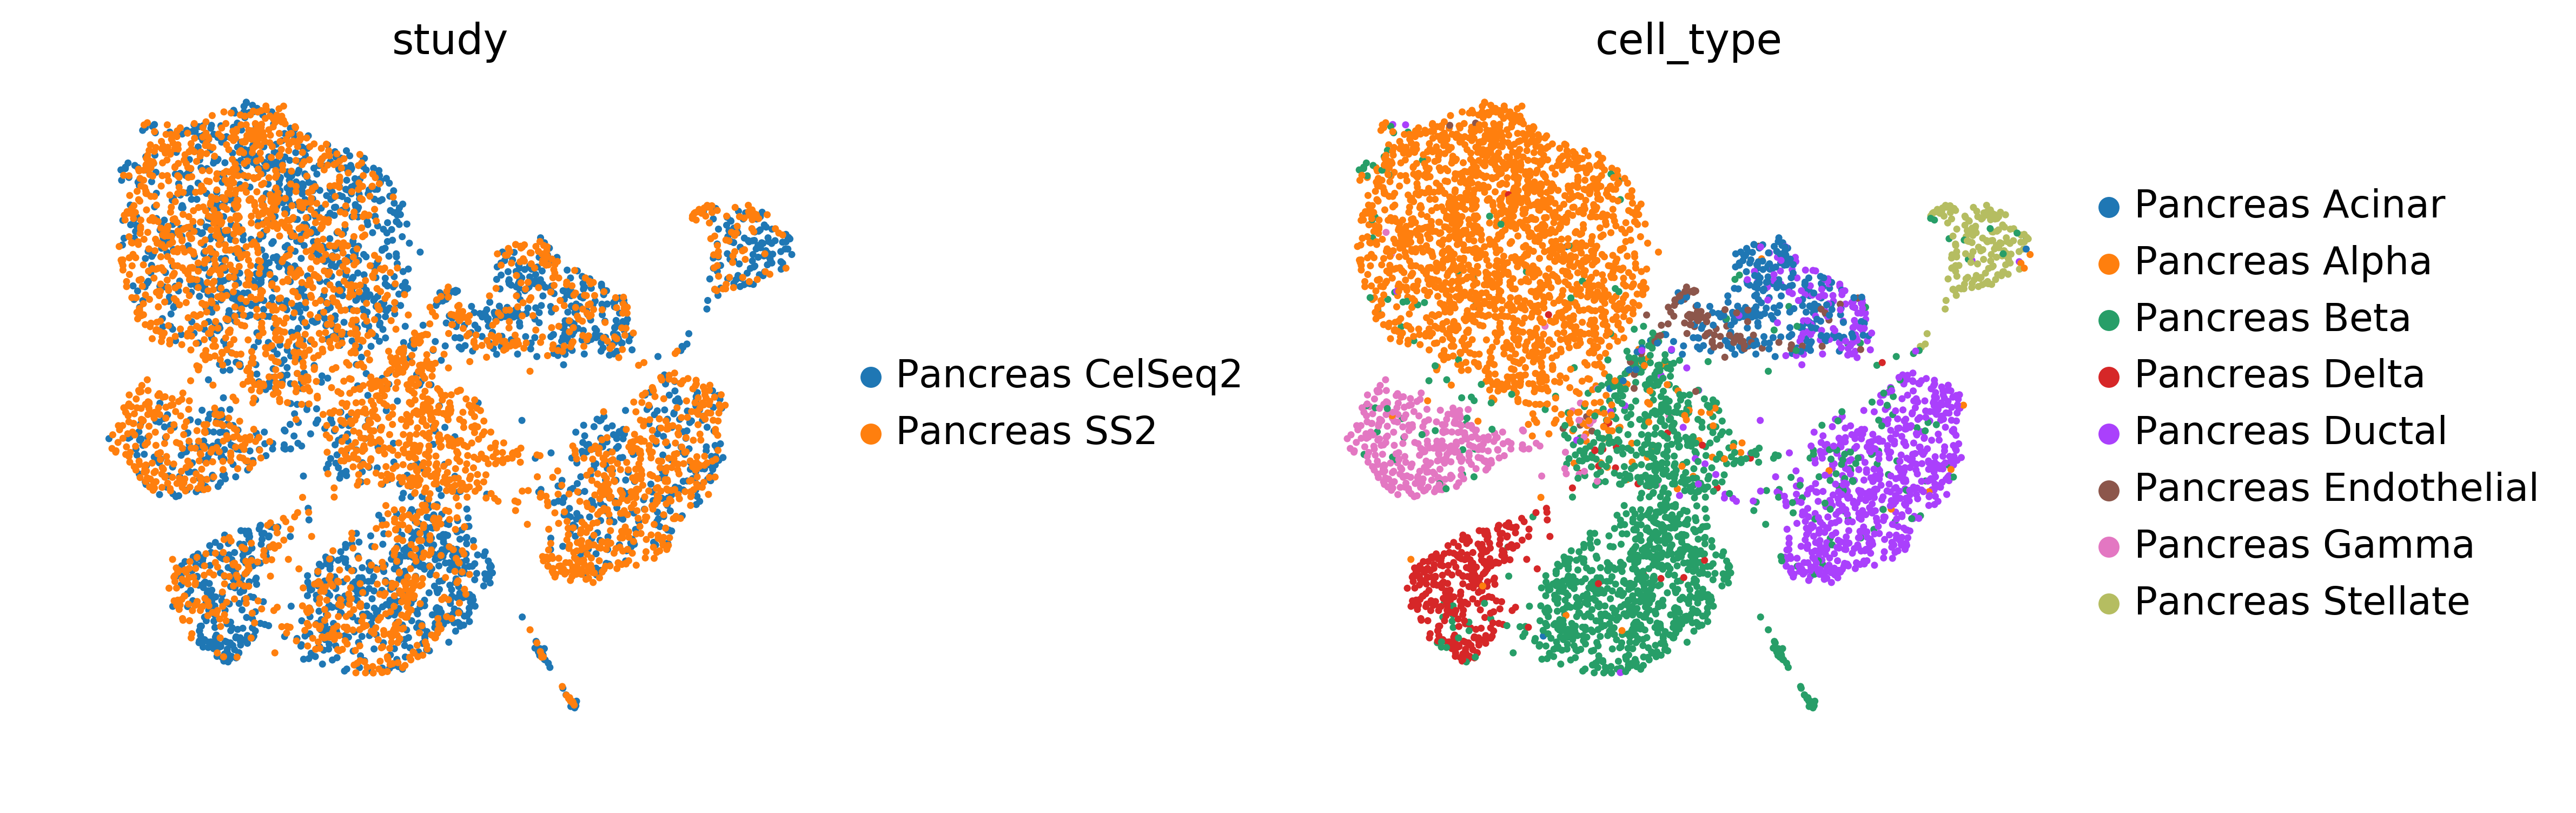

In [31]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

## Projecting All data in to the latent space of the model 

In [33]:
latent_adata = new_network.get_latent(adata, condition_key, return_z=False)

In [34]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

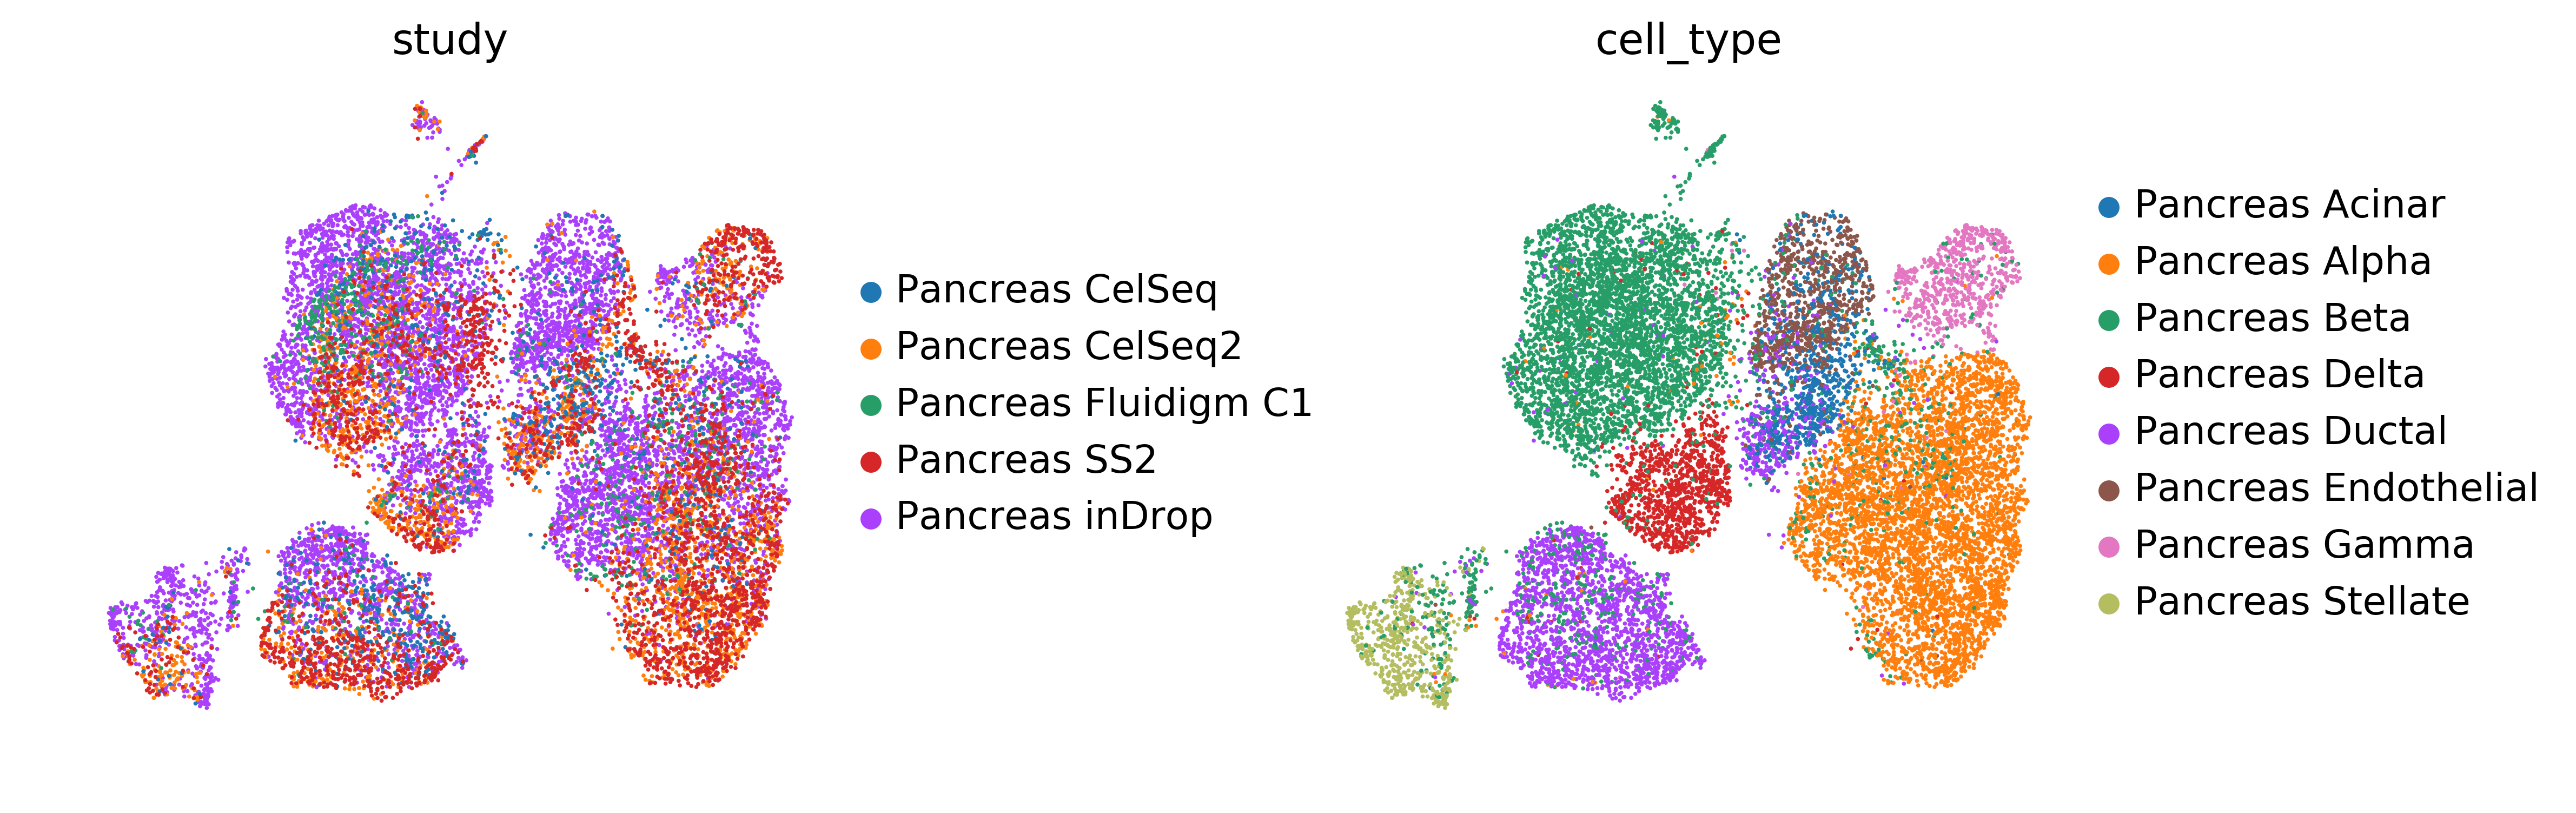

In [35]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

# Weighted KNN

In [22]:
n_neighbors = 20
threhsold = 0.3

In [19]:
train_latent = new_network.get_latent(source_adata, condition_key, return_z=False)

In [20]:
valid_latent = new_network.get_latent(target_adata, condition_key, return_z=False)

In [21]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)

In [23]:
sca.ann.weighted_knn(train_latent, 
                     valid_latent,
                     cell_type_key,
                     n_neighbors=n_neighbors,
                     threshold=threhsold,
                     pred_unknown=True,
                     )

Weighted KNN with n_neighbors = 20 and threshold = 0.3 ... finished!
Number of correctly classified samples: 4690
Number of misclassified samples: 696
Number of samples classified as unknown: 1


In [43]:
true_labels = np.array(valid_latent.obs[cell_type_key].values)
true_labels = true_labels.reshape(-1,)

In [44]:
labels_eval = prediction.reshape(-1,) == np.array(true_labels)
labels_eval = labels_eval.astype(object)

n_correct = len(labels_eval[labels_eval == True])
n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[prediction == 'Unknown'])
n_unknown = len(labels_eval[prediction == 'Unknown'])

labels_eval[labels_eval == True] = f'Correct ({n_correct})'
labels_eval[labels_eval == False] = f'InCorrect ({n_incorrect})'
labels_eval[prediction == 'Unknown'] = f'Unknown ({n_unknown})'

In [45]:
valid_latent.obs['prediction'] = prediction.reshape(-1,)
valid_latent.obs['uncertainty'] = uncertainties.reshape(-1,)
valid_latent.obs['evaluation'] = labels_eval

... storing 'pred_cell_type' as categorical
... storing 'evaluation' as categorical


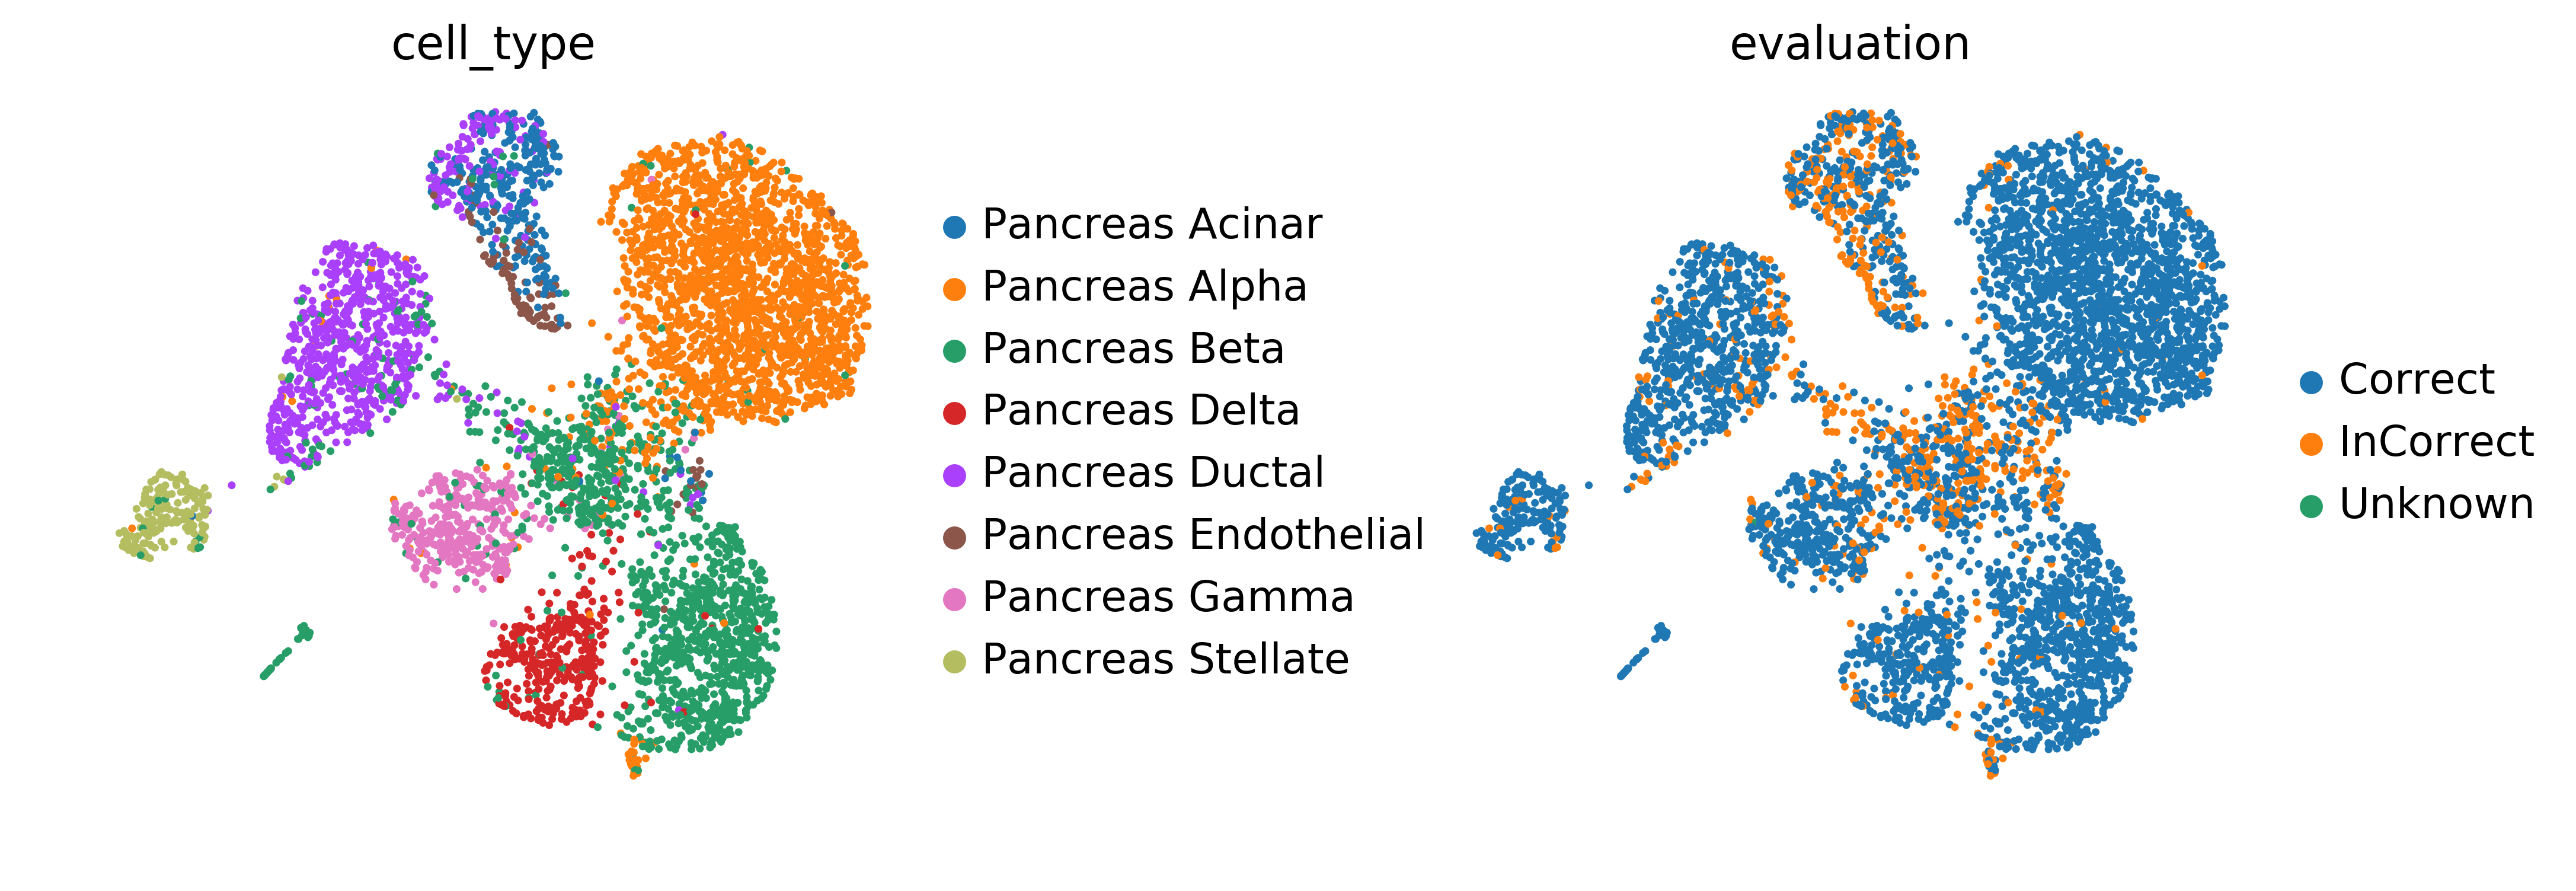

In [24]:
sc.pl.umap(valid_latent, color=[cell_type_key, 'evaluation'], wspace=0.5, frameon=False)

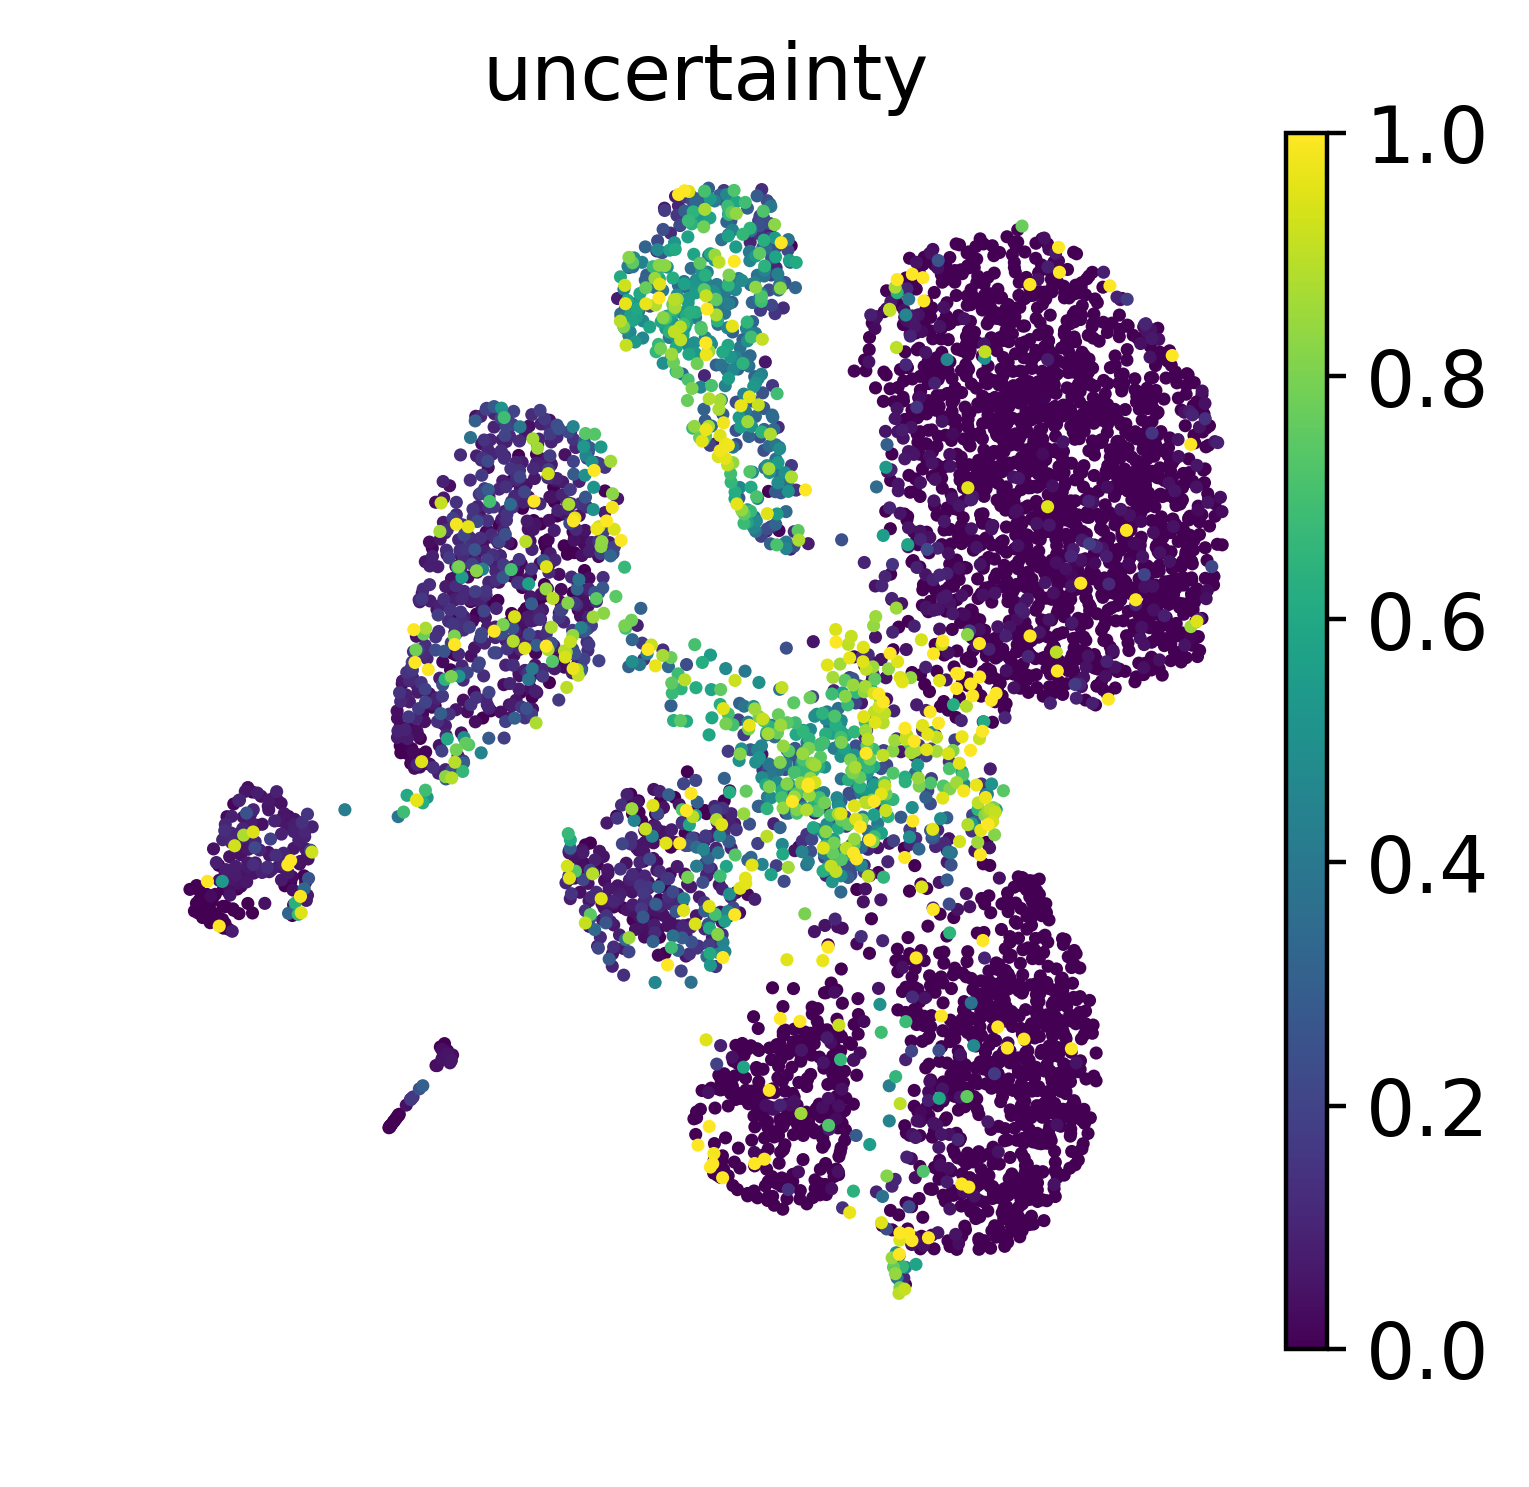

In [25]:
sc.pl.umap(valid_latent, color='uncertainty', frameon=False)

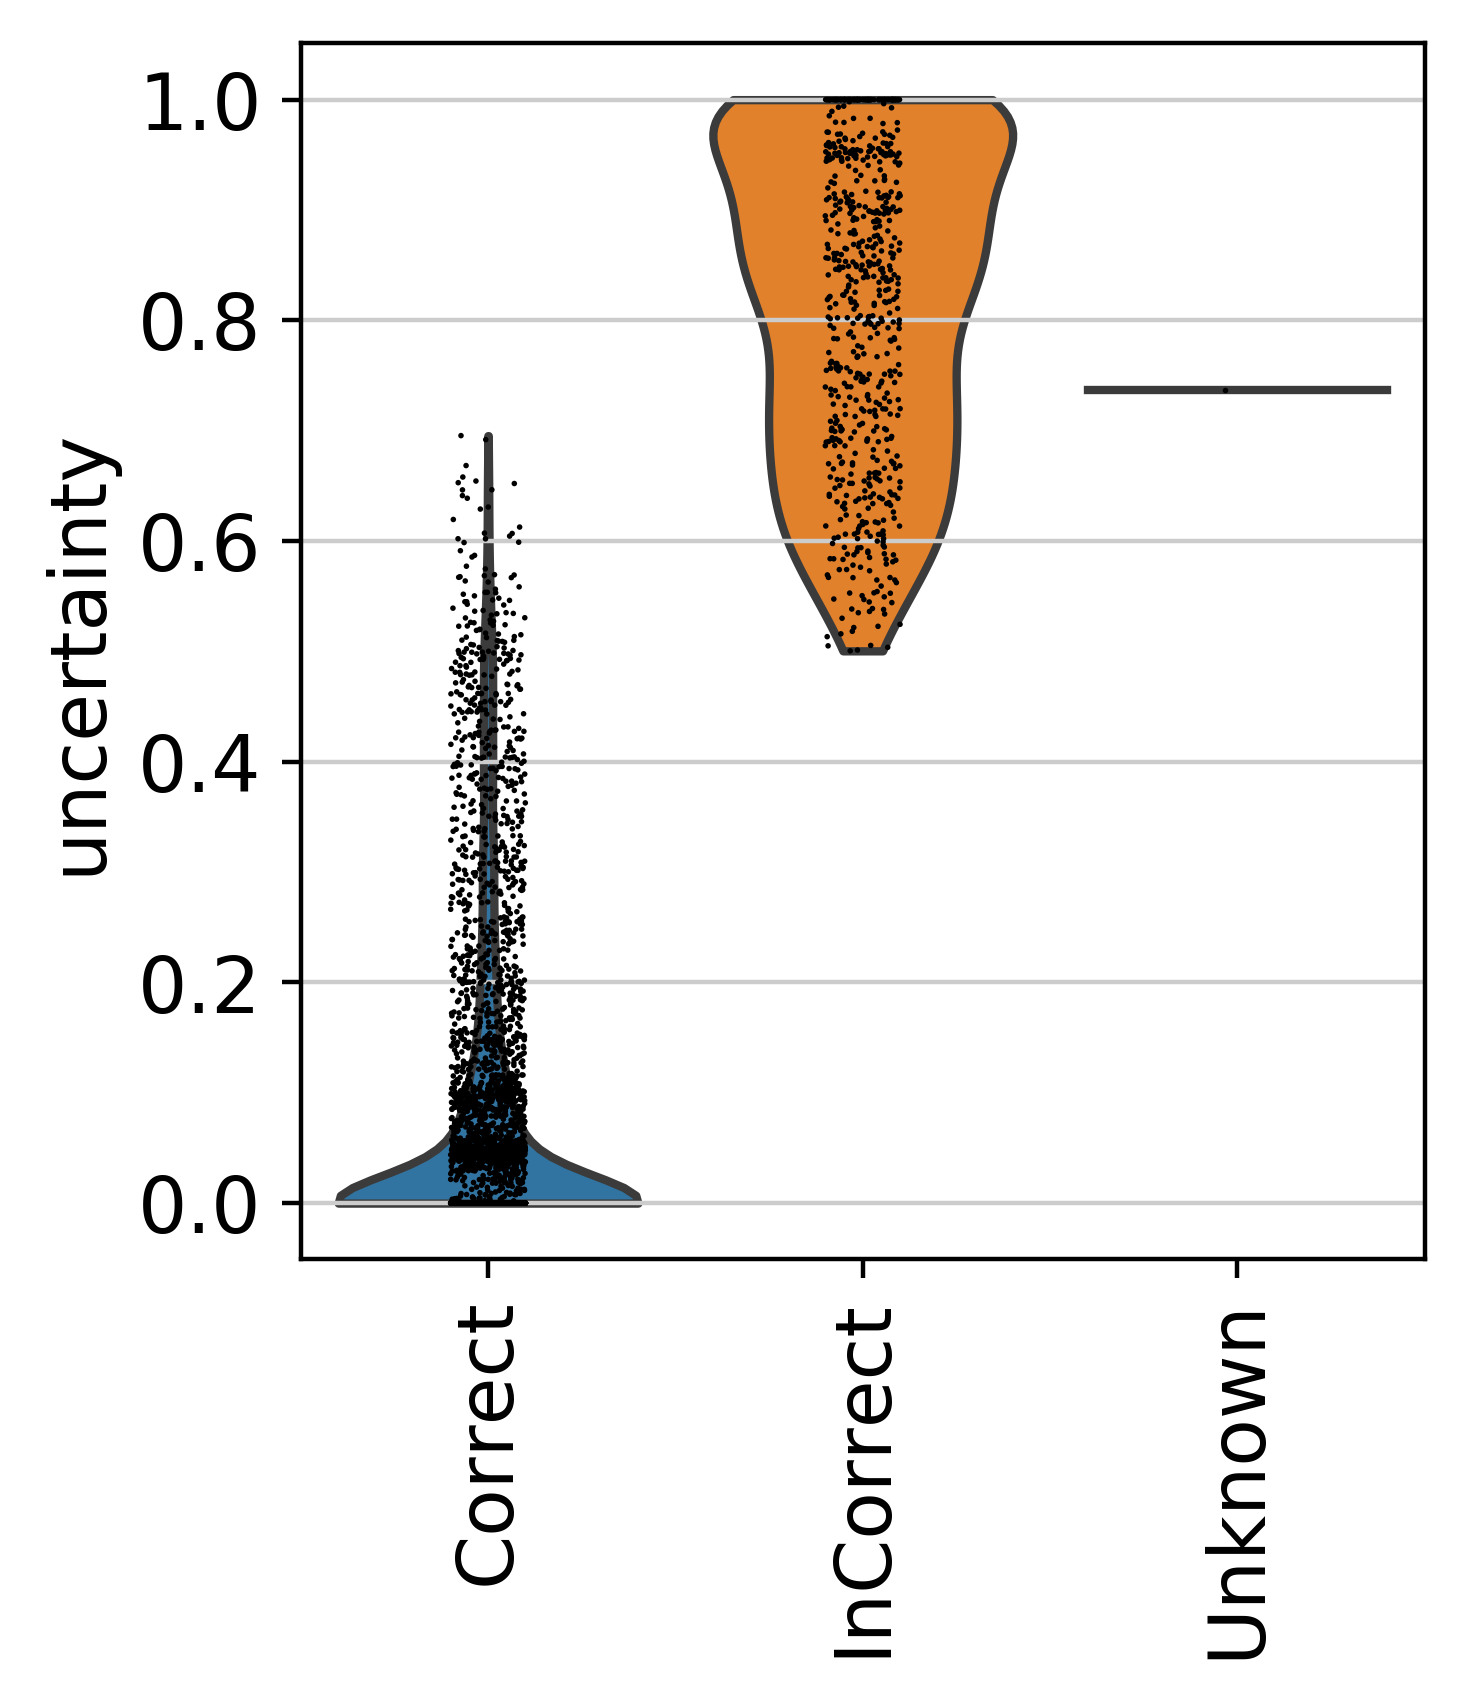

In [26]:
sc.pl.violin(valid_latent, keys='uncertainty', groupby='evaluation', rotation=90)

In [27]:
cell_types = valid_latent.obs[cell_type_key].unique().tolist()

In [29]:
results_df = pd.DataFrame(columns=['cell type', 'Correct', 'InCorrect', 'Unknown'])
for cell_type in cell_types:
    labels_eval_key = f'pred_{cell_type_key}'

    cell_latent = valid_latent[valid_latent.obs[cell_type_key] == cell_type]

    pred_labels = cell_latent.obs[labels_eval_key].values
    true_labels = cell_latent.obs[cell_type_key].values

    labels_eval = np.array(pred_labels) == np.array(true_labels)

    n_correct = len(labels_eval[labels_eval == True])
    n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
    n_unknown = len(labels_eval[pred_labels == 'Unknown'])
    
    new_row = {"cell type": f"{cell_type} ({cell_latent.shape[0]})"}

    new_row['Correct'] = n_correct
    new_row['InCorrect'] = n_incorrect
    new_row['Unknown'] = n_unknown

    results_df = results_df.append(new_row, ignore_index=True)

In [30]:
results_df = results_df.sort_values('Correct', ascending=False)
results_df_melted = pd.melt(results_df, id_vars=['cell type'], var_name='type', value_name='n_samples')

In [31]:
sns.set(style='whitegrid')
color_palette = sns.color_palette("cubehelix", 3)

In [32]:
barplot = sns.catplot(x='cell type', y='n_samples', hue='type', data=results_df_melted, 
                      kind='bar', height=10, aspect=3, legend_out=False, palette=color_palette)


plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("")
plt.xlabel("")
plt.show()
plt.close()